In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path(r"D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset")

Buat File Dataframe

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    # Ambil sampel dari setiap kategori dengan maksimum 600 gambar
    category_samples.append(category_slice.sample(min(6000, len(category_slice)), random_state=1, replace=False))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [4]:
image_df

,Filepath,Label
0,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Gogos
1,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Gogos
2,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sop Konro
3,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
4,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
...,...,...
6793,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
6794,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sokko
6795,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
6796,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras


In [5]:
image_df['Label'].value_counts()

Label
Gogos        1133
Sop Konro    1133
Kapurung     1133
Buras        1133
Dangkot      1133
Sokko        1133
Name: count, dtype: int64

In [6]:
#train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
train_dir = r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\train'
val_dir =r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\val'
test_dir=r'D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\test'

Buat Train Generator

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_directory(
    directory=train_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
    #subset='training'
)

val_images = train_generator.flow_from_directory(
    directory=val_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
    #subset='validation'
)

test_images = test_generator.flow_from_directory(
    directory=test_dir,
    #x_col='Filepath',
    #y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 4758 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.
Found 1020 images belonging to 6 classes.


Modelling

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


#print(model.summary())

Training

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        f1_score,
    ]
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8465 - auc: 0.7610 - f1_score: 0.4669 - loss: 4.4155 - precision: 0.5460 - recall: 0.4262 - val_accuracy: 0.9533 - val_auc: 0.9760 - val_f1_score: 0.8479 - val_loss: 0.4822 - val_precision: 0.9248 - val_recall: 0.7833
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9502 - auc: 0.9743 - f1_score: 0.8435 - loss: 0.4912 - precision: 0.8849 - recall: 0.8067 - val_accuracy: 0.9642 - val_auc: 0.9886 - val_f1_score: 0.8889 - val_loss: 0.3220 - val_precision: 0.9176 - val_recall: 0.8627
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9625 - auc: 0.9862 - f1_score: 0.8846 - loss: 0.3414 - precision: 0.9069 - recall: 0.8639 - val_accuracy: 0.9526 - val_auc: 0.9719 - val_f1_score: 0.8548 - val_loss: 0.5239 - val_precision: 0.8732 - val_recall: 0.8373
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9668 - auc: 0.9874 - f1_score: 0.8977 - loss: 0.3149 - precision: 0.9151 - recall: 0.8824 - va

Result

In [13]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 96.80%


In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


In [15]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt 
def Train_Val_plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle("VISUALIZE THE PERFORMANCE MATRICS")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend(['training', 'validation'])
    plt.show()


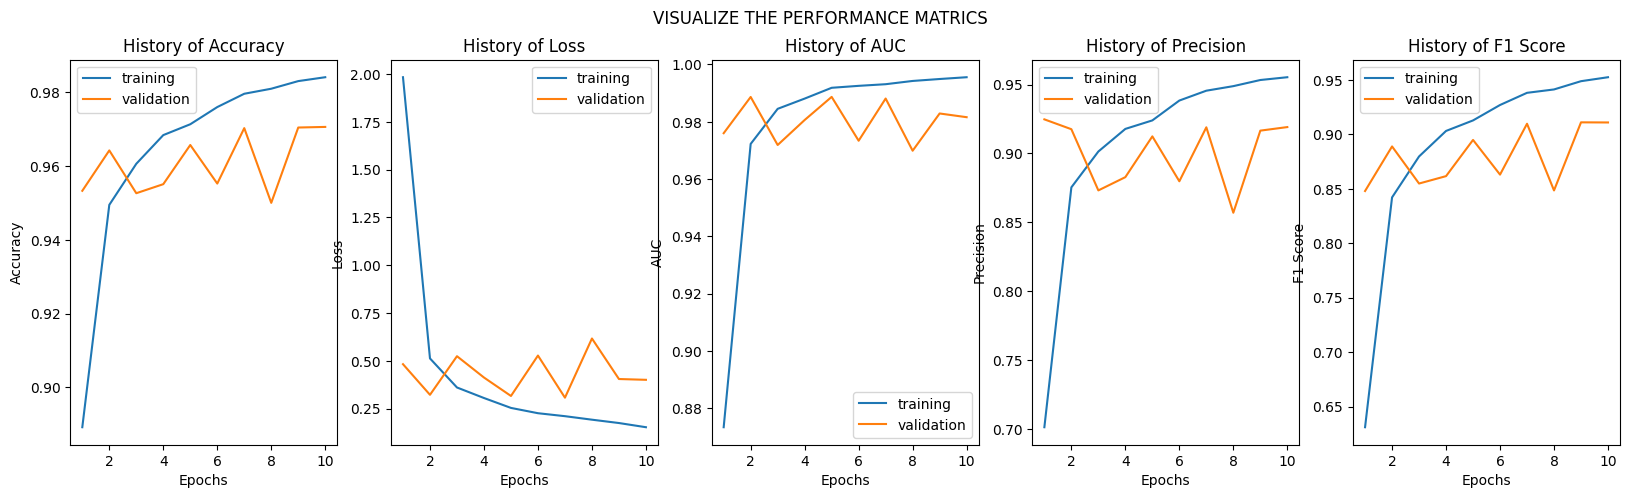

In [16]:
Train_Val_plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])

In [17]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

       Buras       0.89      0.94      0.91       170
     Dangkot       0.86      0.82      0.84       170
       Gogos       0.97      0.95      0.96       170
    Kapurung       0.86      0.95      0.91       170
       Sokko       0.88      0.94      0.91       170
   Sop Konro       0.95      0.82      0.88       170

    accuracy                           0.90      1020
   macro avg       0.90      0.90      0.90      1020
weighted avg       0.90      0.90      0.90      1020



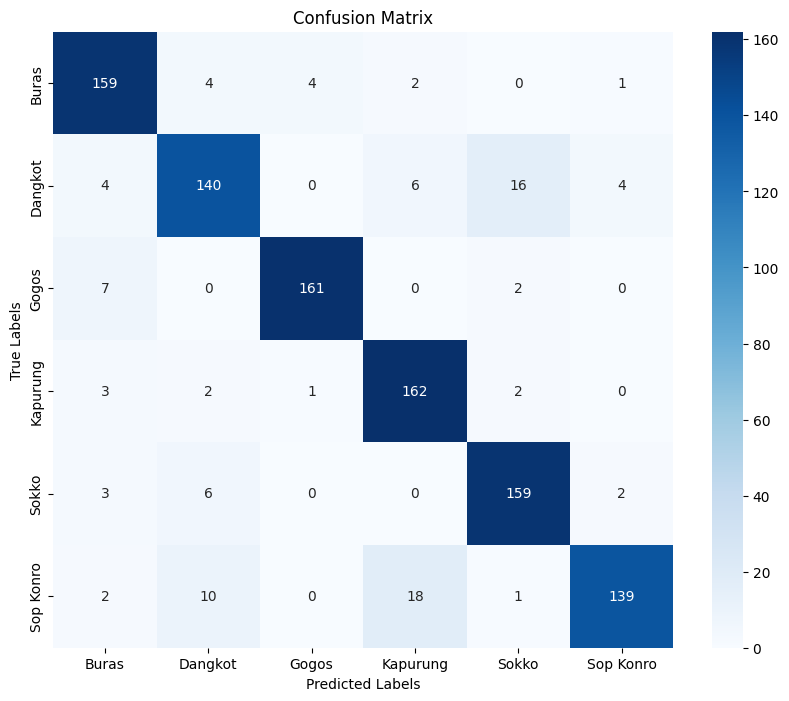

In [18]:
# Import required libraries
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [19]:
# Saving the model
model.save('Percobaan10_Mobilenetv2.h5')

Deteksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions shape: (1, 6)
Predicted class: Gogos


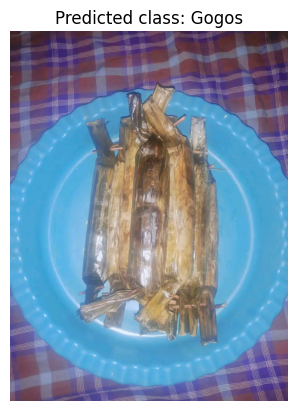

In [20]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Load the custom MobileNetV2 model
model = load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\Codingan\Percobaan10_Mobilenetv2.h5")

# Define the class names
class_names = ['Buras', 'Dangkot', 'Gogos', 'Kapurung', 'Sokko', 'Sop Konro']

# Define the path to your image
image_path = r"E:\Dataset\Gogos\1715183308117.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran dengan ukuran input model Anda
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make prediction
preds = model.predict(x)

# Check the shape of the predictions
print("Predictions shape:", preds.shape)

# Get the index of the highest probability prediction
pred_index = np.argmax(preds)

# Initialize the predicted class variable
predicted_class = "Predicted index is out of range"

# Check if pred_index is within the range of class_names
if pred_index < len(class_names):
    # Get the predicted class label
    predicted_class = class_names[pred_index]

# Print the predicted class label
print("Predicted class:", predicted_class)

# Display the image along with the predicted class
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()